In [96]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import math
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [70]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    # Get the embeddings from the last hidden state
    embeddings = outputs.last_hidden_state
    # Pool the embeddings (use mean pooling for simplicity)
    pooled_embeddings = torch.mean(embeddings, dim=1)
    return pooled_embeddings.detach().numpy()

/Users/ignatiocalvin/anaconda3/envs/dowJones/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [117]:
df = pd.read_csv('../data/upload_DJIA_table.csv', parse_dates=['Date'], index_col='Date')
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df_close = df[['Close']]
df_ema = df[['EMA_10']]

df_close = df_close.sort_index()
df_ema = df_ema.sort_index()

# df_close
training_data_len = math.ceil(len(df_close) * .8)
training_data_len

train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(1592, 1) (397, 1)


In [118]:
# make df_ema into train and test
train_data_ema = df_ema[:training_data_len]
test_data_ema = df_ema[training_data_len:]

In [119]:
# Selecting Open Price values
dataset_train = train_data.values
dataset_test = test_data.values

# Selecting EMA values
dataset_train_ema = train_data_ema.values
dataset_test_ema = test_data_ema.values

dataset_test.shape, dataset_train.shape

((397, 1), (1592, 1))

In [120]:
bert_embeddings = np.load('../bert_embeddings.npy')

bert_train = bert_embeddings[:training_data_len]
bert_test = bert_embeddings[training_data_len:]
print(bert_train.shape, bert_test.shape)

(1592, 1, 768) (397, 1, 768)


In [121]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
scaled_train_ema = scaler.fit_transform(dataset_train_ema)

print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
scaled_test_ema = scaler.fit_transform(dataset_test_ema)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test


[[0.9547063 ]
 [0.930197  ]
 [0.90044237]
 [0.8696714 ]
 [0.88875926]]
[0.76733678] [0.74467061] [0.73538647] [0.73724904] [0.73684403]


In [122]:
# Create sequences and labels for training data
sequence_length = 50 # Number of time steps to look back
X_train_emb, X_train_ema, X_train, y_train = [], [], [], []
# asd = []

for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
    X_train_emb.append(bert_train[i:i+sequence_length])
    X_train_ema.append(scaled_train_ema[i:i+sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train_emb = np.array(X_train_emb)
X_train_ema = np.array(X_train_ema)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).float()
y_train = torch.tensor(y_train, dtype=torch.float32).float()
X_train_emb = torch.tensor(X_train_emb, dtype=torch.float32).float().squeeze()
X_train_ema = torch.tensor(X_train_ema, dtype=torch.float32).float()


X_train.shape, X_train_emb.shape, X_train_ema.shape, y_train.shape


(torch.Size([1542, 50, 1]),
 torch.Size([1542, 50, 768]),
 torch.Size([1542, 50, 1]),
 torch.Size([1542, 50, 1]))

In [123]:
X_train = torch.cat((X_train, X_train_ema, X_train_emb), axis=2)
X_train.shape

torch.Size([1542, 50, 770])

In [124]:
# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, X_test_emb, X_test_ema, y_test = [], [], [], []


for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
    X_test_emb.append(bert_test[i:i+sequence_length])
    X_test_ema.append(scaled_test_ema[i:i+sequence_length])
    

X_test, X_test_emb, y_test = np.array(X_test), np.array(X_test_emb), np.array(y_test)
X_test_ema = np.array(X_test_ema)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
X_test_emb = torch.tensor(X_test_emb, dtype=torch.float32).squeeze()
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test_ema = torch.tensor(X_test_ema, dtype=torch.float32)

X_test.shape, X_test_emb.shape, X_test_ema.shape, y_test.shape

(torch.Size([367, 30, 1]),
 torch.Size([367, 30, 768]),
 torch.Size([367, 30, 1]),
 torch.Size([367, 30, 1]))

In [125]:
X_test = torch.cat((X_test, X_test_emb, X_test_ema), axis=2)
X_test.shape

torch.Size([367, 30, 770])

In [126]:
class LSTMModel(nn.Module):
	# input_size : number of features in input at each time step
	# hidden_size : Number of LSTM units 
	# num_layers : number of LSTM layers
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(64, 1)

    def forward(self, p): # defines forward pass of the neural network
        out, _ = self.lstm(p)
        out = self.linear(out)
        return out


In [127]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [128]:
input_size = 770
# input_emb = 769
num_layers = 2
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)


LSTMModel(
  (lstm): LSTM(770, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [129]:
X_train.shape

torch.Size([1542, 50, 770])

In [130]:
from torch.utils.data import TensorDataset, DataLoader


batch_size = 16
# Create DataLoader for batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [131]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_price, batch_y in train_loader:
		batch_price, batch_y = batch_price.to(device), batch_y.to(device)
		predictions = model(batch_price)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_price,  batch_y_test in test_loader:
			batch_price, batch_y_test = batch_price.to(device), batch_y_test.to(device)
			predictions_test = model(batch_price)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/50] - Training Loss: 0.0008, Test Loss: 0.1114
Epoch [20/50] - Training Loss: 0.0003, Test Loss: 0.0909
Epoch [30/50] - Training Loss: 0.0001, Test Loss: 0.0752
Epoch [40/50] - Training Loss: 0.0000, Test Loss: 0.0649
Epoch [50/50] - Training Loss: 0.0005, Test Loss: 0.0565


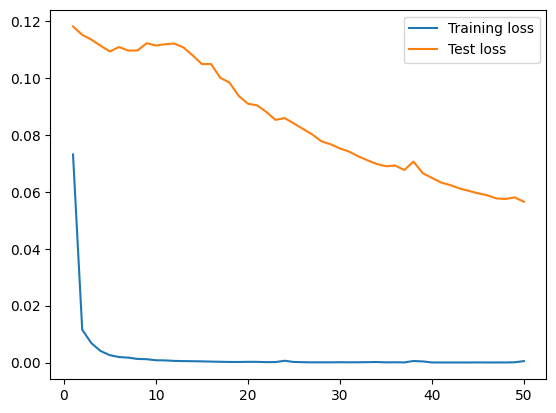

In [132]:
import matplotlib.pyplot as plt

x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


In [133]:
### Lets Do the prediction and check performance metrics
with torch.no_grad():
    train_predict=model(X_train)
    test_predict=model(X_test)

In [134]:
train_predict.shape

torch.Size([1542, 50, 1])

In [135]:
train_predict = train_predict.squeeze()
test_predict = test_predict.squeeze()


In [136]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [137]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

t = scaler.inverse_transform(y_train.squeeze())

math.sqrt(mean_squared_error(t,train_predict))

34.597518962160265

In [138]:
tt = scaler.inverse_transform(y_test.squeeze())
tt.shape

(367, 30)

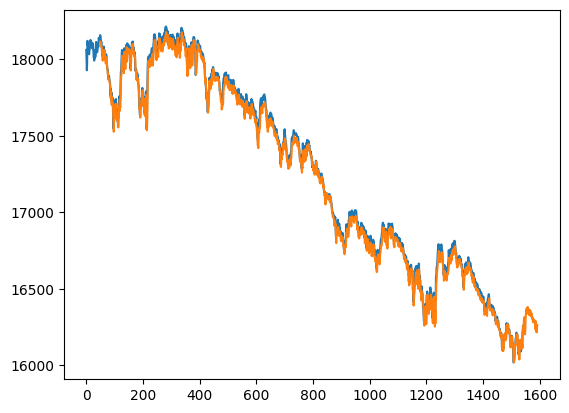

In [139]:
look_back=50
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict[:, -1].reshape(-1, 1)

plt.plot(t[:, 0])
plt.plot(trainPredictPlot[:, -1])

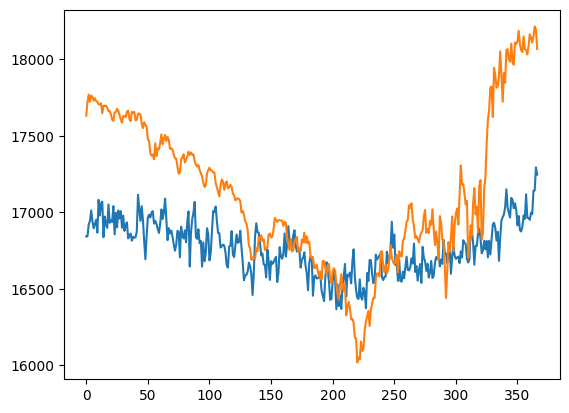

In [141]:
plt.plot(test_predict[:, -1])
plt.plot(tt[:, -1])
plt.show()